# 02 - Ajustement du modele Dixon-Coles

**Objectif** : Fitter le modele Dixon-Coles sur les donnees historiques de Ligue 1 et verifier que les parametres sont coherents.

## Ce qu'on verifie :
1. Le MLE converge correctement
2. Les ratings attack/defense sont coherents avec le classement reel
3. Le parametre rho est dans les bornes attendues (-0.3 a 0)
4. Le home advantage est realiste (0.1 a 0.4)
5. Les predictions de score sont sensees

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from src.models.dixon_coles import DixonColesModel, MatchResult

sns.set_theme(style='whitegrid')
print('OK')

OK


## 1. Charger les donnees d'entrainement

In [2]:
# Charger saison 2023-24 (entrainement)
DATA_DIR = PROJECT_ROOT / 'data' / 'raw'
df = pd.read_csv(DATA_DIR / 'ligue1_2023.csv')
df['kickoff'] = pd.to_datetime(df['kickoff'])
print(f'Matchs charges: {len(df)}')
print(f'Equipes: {df["home_team"].nunique()}')
print(f'Periode: {df["kickoff"].min().date()} -> {df["kickoff"].max().date()}')
df.head()

Matchs charges: 306
Equipes: 18
Periode: 2023-08-11 -> 2024-05-19


,home_team,away_team,home_score,away_score,kickoff,matchday,total_goals,result
0,OGC Nice,Lille OSC,1,1,2023-08-11 19:00:00+00:00,1,2,D
1,Olympique de Marseille,Stade de Reims,2,1,2023-08-12 15:00:00+00:00,1,3,H
2,Paris Saint-Germain FC,FC Lorient,0,0,2023-08-12 19:00:00+00:00,1,0,D
3,Stade Brestois 29,Racing Club de Lens,3,2,2023-08-13 11:00:00+00:00,1,5,H
4,Clermont Foot 63,AS Monaco FC,2,4,2023-08-13 13:00:00+00:00,1,6,A


## 2. Convertir en MatchResult et fitter

In [3]:
%%time

# Convertir en MatchResult
match_results = [
    MatchResult(
        home_team=row['home_team'],
        away_team=row['away_team'],
        home_goals=int(row['home_score']),
        away_goals=int(row['away_score']),
        date=row['kickoff'].to_pydatetime(),
    )
    for _, row in df.iterrows()
]

print(f'Matchs pour fitting: {len(match_results)}')

# Fitter le modele
model = DixonColesModel(half_life_days=180)
model.fit(match_results)

print(f'\nConvergence: {model._convergence_info}')
print(f'Home advantage: {model.home_advantage:.3f}')
print(f'Rho: {model.rho:.3f}')
print(f'Avg goals: {model.avg_goals:.3f}')
print(f'Equipes fittees: {len(model.teams)}')

2026-02-07 12:33:16.928 | INFO     | src.models.dixon_coles:fit:179 - Fitting Dixon-Coles on 306 matches, 18 teams, avg_goals=1.383


Matchs pour fitting: 306


2026-02-07 12:33:24.798 | INFO     | src.models.dixon_coles:fit:245 - MLE converged in 11 iterations


2026-02-07 12:33:24.799 | INFO     | src.models.dixon_coles:fit:261 - Fitted: home_adv=0.049, rho=-0.082, teams=18



Convergence: converged
Home advantage: 0.049
Rho: -0.082
Avg goals: 1.383
Equipes fittees: 18
CPU times: user 7.73 s, sys: 1.25 s, total: 8.98 s
Wall time: 7.88 s


## 3. Classement des equipes par force

In [4]:
# Classement par ratio attack/defense
rankings = model.get_team_rankings()
df_rank = pd.DataFrame(rankings)
print('\nClassement par force (attack/defense ratio):\n')
print(df_rank.to_string(index=False))


Classement par force (attack/defense ratio):

                  team  attack  defense  strength
Paris Saint-Germain FC   1.709    0.800     2.135
          AS Monaco FC   1.451    0.859     1.689
     Stade Brestois 29   1.161    0.774     1.501
             Lille OSC   1.152    0.780     1.476
              OGC Nice   0.893    0.693     1.289
Olympique de Marseille   1.118    0.917     1.220
   Racing Club de Lens   0.964    0.797     1.210
 Stade Rennais FC 1901   1.158    1.039     1.114
    Olympique Lyonnais   1.198    1.156     1.036
           Toulouse FC   0.959    0.985     0.974
       Montpellier HSC   0.948    1.049     0.904
        Stade de Reims   0.865    1.001     0.864
  RC Strasbourg Alsace   0.841    1.092     0.770
           Le Havre AC   0.714    0.986     0.725
            FC Lorient   0.928    1.406     0.660
               FC Metz   0.784    1.235     0.635
             FC Nantes   0.580    1.131     0.513
      Clermont Foot 63   0.577    1.299     0.444


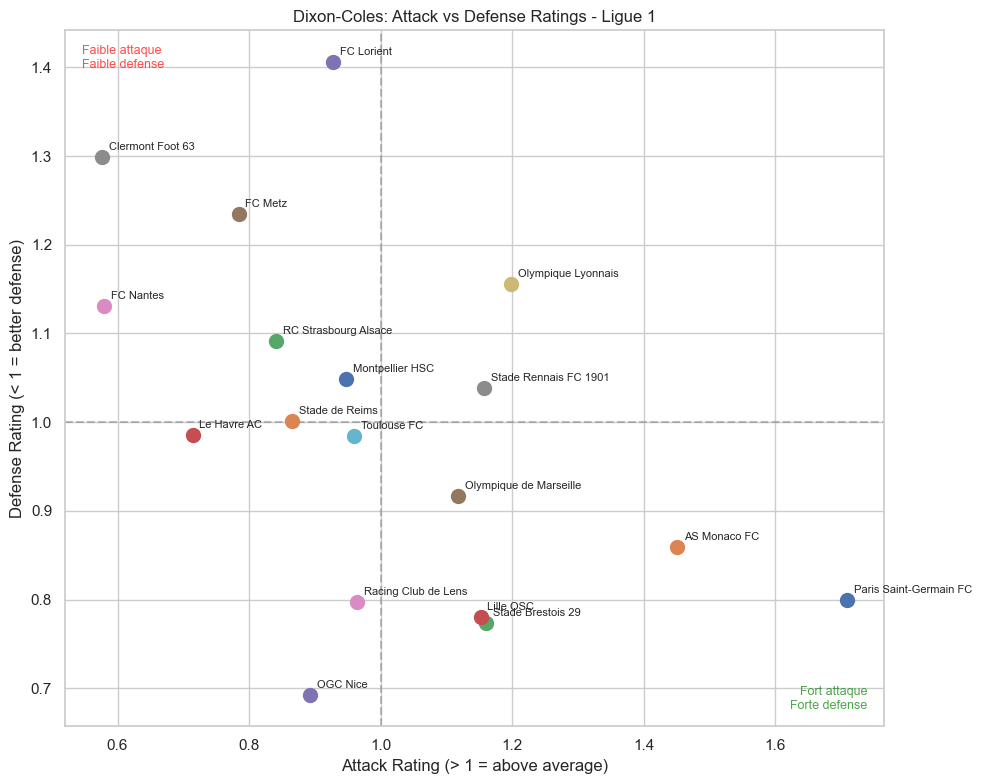

In [5]:
# Visualisation attack vs defense
fig, ax = plt.subplots(figsize=(10, 8))

for _, row in df_rank.iterrows():
    ax.scatter(row['attack'], row['defense'], s=100, zorder=5)
    ax.annotate(row['team'], (row['attack'], row['defense']),
                textcoords='offset points', xytext=(5, 5), fontsize=8)

ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Attack Rating (> 1 = above average)')
ax.set_ylabel('Defense Rating (< 1 = better defense)')
ax.set_title('Dixon-Coles: Attack vs Defense Ratings - Ligue 1')

# Quadrant labels
ax.text(0.98, 0.02, 'Fort attaque\nForte defense', transform=ax.transAxes,
        ha='right', va='bottom', fontsize=9, color='green', alpha=0.7)
ax.text(0.02, 0.98, 'Faible attaque\nFaible defense', transform=ax.transAxes,
        ha='left', va='top', fontsize=9, color='red', alpha=0.7)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'data' / 'results' / 'team_ratings.png', dpi=150)
plt.show()

## 4. Test de prediction

In [6]:
# Predire quelques matchs pour verifier la coherence
test_matchups = [
    ('Paris Saint-Germain FC', 'Montpellier HSC'),   # Gros favori
    ('Paris Saint-Germain FC', 'AS Monaco FC'),       # Choc
    ('Montpellier HSC', 'Le Havre AC'),               # Bas de tableau
]

teams_available = list(model.teams.keys())
print('Equipes disponibles:', teams_available[:5], '...')
print()

for home, away in test_matchups:
    if home not in model.teams or away not in model.teams:
        print(f'\n[SKIP] {home} vs {away} - equipe non trouvee')
        continue
    
    pred = model.predict(home, away)
    d = pred.to_dict()
    print(f"\n{home} vs {away}")
    print(f"  Lambda: {d['lambda_home']:.2f} - {d['lambda_away']:.2f}")
    print(f"  1X2: {d['1x2']['home']:.1%} / {d['1x2']['draw']:.1%} / {d['1x2']['away']:.1%}")
    print(f"  O/U 2.5: {d['over_under']['over_25']:.1%} / {1-d['over_under']['over_25']:.1%}")
    print(f"  BTTS: {d['btts']['yes']:.1%} / {d['btts']['no']:.1%}")

Equipes disponibles: ['AS Monaco FC', 'Clermont Foot 63', 'FC Lorient', 'FC Metz', 'FC Nantes'] ...


Paris Saint-Germain FC vs Montpellier HSC
  Lambda: 2.60 - 1.05
  1X2: 70.0% / 17.4% / 12.5%
  O/U 2.5: 70.6% / 29.4%
  BTTS: 60.8% / 39.2%

Paris Saint-Germain FC vs AS Monaco FC
  Lambda: 2.13 - 1.61
  1X2: 49.2% / 22.2% / 28.6%
  O/U 2.5: 72.1% / 27.9%
  BTTS: 71.1% / 28.9%

Montpellier HSC vs Le Havre AC
  Lambda: 1.36 - 1.04
  1X2: 43.0% / 29.4% / 27.6%
  O/U 2.5: 42.9% / 57.1%
  BTTS: 49.0% / 51.0%


## 5. Verification rapide sur les matchs termines

On predit les matchs de la saison d'entrainement (in-sample) pour verifier que le modele n'est pas completement a cote.

In [7]:
# Prediction in-sample (attention: c'est du in-sample, pas du out-of-sample!)
correct = 0
total = 0
probs_home = []

for _, row in df.iterrows():
    h, a = row['home_team'], row['away_team']
    if h not in model.teams or a not in model.teams:
        continue
    
    pred = model.predict(h, a)
    predicted = max(
        [('H', pred.home_win), ('D', pred.draw), ('A', pred.away_win)],
        key=lambda x: x[1]
    )[0]
    
    # Resultat reel
    hs, as_ = int(row['home_score']), int(row['away_score'])
    actual = 'H' if hs > as_ else ('D' if hs == as_ else 'A')
    
    if predicted == actual:
        correct += 1
    total += 1
    probs_home.append(pred.home_win)

print(f'Accuracy in-sample: {correct/total:.1%} ({correct}/{total})')
print(f'(Attention: c est du in-sample, le vrai test est dans notebook 05_backtest)')
print(f'\nProba home win moyenne: {np.mean(probs_home):.3f}')
print(f'Home win rate reel:     {(df["home_score"] > df["away_score"]).mean():.3f}')

Accuracy in-sample: 52.9% (162/306)
(Attention: c est du in-sample, le vrai test est dans notebook 05_backtest)

Proba home win moyenne: 0.388
Home win rate reel:     0.392


## Prochaine etape

Le modele Dixon-Coles est fitte. Passons au notebook **03** pour le modele ELO, puis au **05_backtest** pour la validation walk-forward.